# Notes and Observations 
After updating the model to use the academic researched varying thermal properties, the time remained practically the same as using the googled averages. The time suggested is unfortunately twice as high as it actually takes to boil an egg with a runny yolk which was found to be approx 5 minutes starting at T = 100. Repeating the practical experiment placing the egg in room temp water took 5.5 min to boil and another 2-3 minutes to cook. 

In trying to adjust the model to agree with the 5 min cook time, I adjusted the thermal properties to their most extreme references and still found a prediction of 10.45 minutes. Doing a real cook time of 6 mins reveals 5mm of cooked yolk. 10.45 minutes would certainly see a cooked center. The issue must then lie in the mathematical model I derived, which held temp constant at the shell and used energy in at the center cutting the egg in half. 

Playing with the thermal properties I tried to get a window where the yolk/white boundary begins to cook around 5 mins and is fully cooked around 13 mins in an attempt to reach my observed data. Getting the yolk to start cooking at 5 mins took a large but realistic h_conv of 5000, and very unrealistic k of 0.85 for liquid and a realistic 0.35 for cooked. And a small Cp of 1500.

# Trials
My real world experiments worked with eggs of diameter 4.75cm with yolks of 2.5cm in diameter. Eggs were at room temp of 18.5 C 

Trials 1 - 3 used the drop egg in method with T0 = 100.

Trial 1 used the prediction of the original model of 12.5 mins. The yolk center was practically but not fully cooked.

Trial 2 ended at 6 mins with a mostly runny yolk but about 5mm of cooked yolk on the side.

Trial 3 ended at 4 mins with mostly cooked whites but with the yolk/white barrier completely under cooked.

This leads me to conclude that ~5mins is the best cook time with the drop in method.

Trial 4 used room temp water that was brought to boil with the egg in it. It took 5.5 mins for the water to reach boil. I pulled the egg out after 1 min of water boiling. The egg looked identical to trial 3. Concluding with egg and water being brought to temp together, the total cook time would be in the 7 - 8 minute range. The total energy used would be greater using the drop in method as one would need to bring water to a boil (5.5mins) and then cook the egg for an additional 5 mins.

In [78]:

# --- Define Material Property Functions ---
def get_material(r):
    if r <= R_yolk: return "yolk"
    if r <= R_white: return "white"
    return "shell"

def get_k(T, material):
    # Thermal conductivity (W/mK)
    if material == "yolk":
        W_w = 0.518
        if T < 65:
            k = 0.85
            #T_k = T + 273.15  
            #k = 0.276 - 0.0004 * T_k + 0.4302 * W_w
            return k
        else: 
            return 0.35
    if material == "white":
        W_w = 0.882
        if T < 60:
            k = 0.85
            #T_k = T + 273.15 
            #k = 0.276 - 0.0004 * T_k + 0.4302 * W_w
            return k
        else: 
            return 0.45
    else: return 1.5

def get_rho(T, material):
    # Density (kg/m^3)
    if material == "yolk":
        #rho = 1030
        W_w = 0.518
        T_k = T + 273.15 
        rho = 1295.72 - 0.0559 * T_k - 284.43 * W_w
        return rho
    else: return 1036
    if material == "white":
        W_w = 0.882
        if T < 65:
            #rho = 1040
            T_k = T + 273.15  
            rho = 1295.72 - 0.0559 * T_k - 284.43 * W_w
            return rho
        else: 
            return 1036
    else: return 2300

def get_cp(T, material):
    # Specific Heat (J/gK)
    if material == "white":
        W_w = 0.882
        if T < 60:  
            #Cp = 2200
            T_k = T + 273.15  
            Cp = 1000*(0.668 + 0.0025 * T_k + 2.4429 * W_w)
            return Cp
        elif T <= 65: 
            return 3535 # Cp once state change is complete
        else:
            return 8000 # Cp spike due to latent heat
            
    if material == "yolk":
        W_w = 0.518
        if T < 65: 
            #Cp = 2200
            T_k = T + 273.15  
            Cp = 1000*(0.668 + 0.0025 * T_k + 2.4429 * W_w)
            return Cp
        elif T <= 70:
            return 3000 # Cp once state change is complete
        else:
            return 6000 # Cp spike due to latent heat
    else:
        return 888

Starting simulation...
Simulation finished in 0.68 seconds.
Yolk edge begins to cook at 7.78 minutes


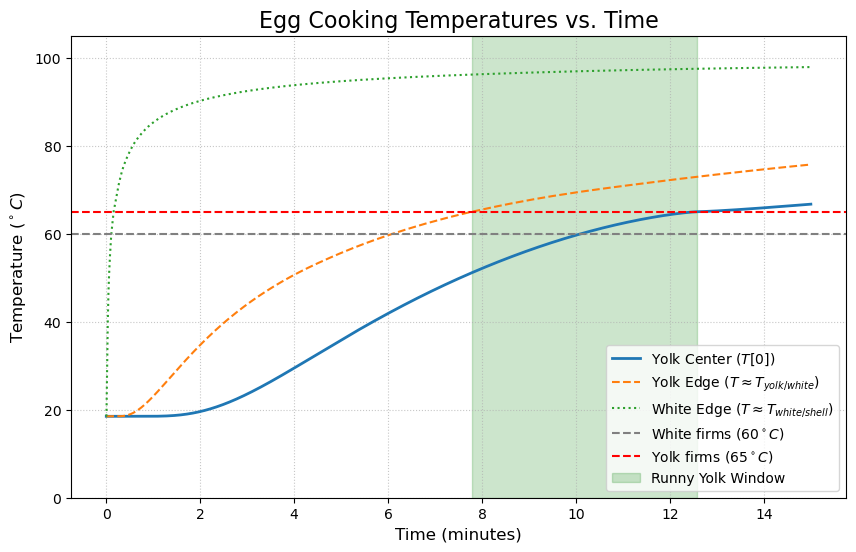

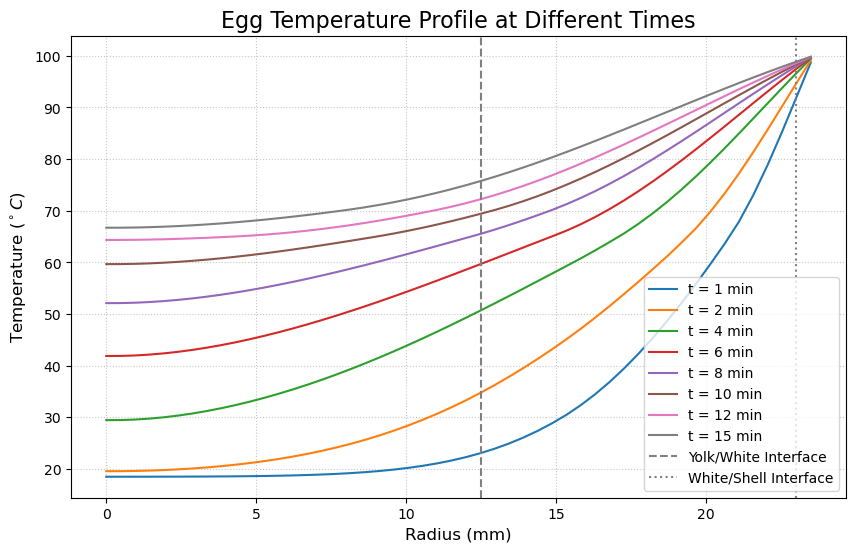

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_egg_simulation():
    """
    Runs a 1D FDM simulation of an egg cooking and plots the results.
    """
    
    # --- 1. Define Constants and Grid ---
    R_yolk = 0.0125   # 1.25 cm radius
    R_white = 0.023  # 2.3 cm radius
    R_shell = 0.0235  # 2.35 cm radius (0.5mm shell)

    N_nodes = 50   
    dr = R_shell / (N_nodes - 1)
    r_nodes = np.linspace(0, R_shell, N_nodes) # Radius at each node

    # Find interface indices
    yolk_white_idx = int(R_yolk / dr)
    white_shell_idx = int(R_white / dr)

    T_initial = 18.5    # 17 C (room temp) 4 C (from the fridge) - Found it takes ~ 1.5 minutes longer starting chilled
    T_water = 100.0  # 100 C
    h_conv = 5000.0    # Convection coeff for boiling water (W/m^2 K)

    # Time setup
    dt = 0.05    # Time step (Seconds)
    max_time = 900       # 15 minutes
    n_steps = int(max_time / dt)
    time_array = np.linspace(0, max_time, n_steps)

    # --- 2. Define Base Material Properties ---
    # Pre-populate property arrays
    k = np.zeros(N_nodes)
    rho = np.zeros(N_nodes)
    cp = np.zeros(N_nodes)

    # --- 3. Initialization ---
    T = np.full(N_nodes, T_initial) # Temp array at current time 'p'
    T_new = np.copy(T)            # Temp array at next time 'p+1'

    # Data storage for plotting
    T_history_center = np.zeros(n_steps)
    T_history_yolk_edge = np.zeros(n_steps)
    T_history_white_edge = np.zeros(n_steps)

    # Storage for T(r) snapshots
    snapshot_times = [60, 120, 240, 360, 480, 600, 720, 900 ] # 1, 2, 4, 6, 8, 10, 12, 15 min
    snapshot_indices = [int(t / dt) - 1 for t in snapshot_times]
    T_snapshots = []

    # Get node indices for vectorization
    i = np.arange(1, N_nodes - 1) # Internal nodes
    
    print("Starting simulation...")
    start_time = time.time()
    
    # --- 4. Time-Stepping Loop ---
    for p in range(n_steps):
        
        # --- 4a. Calculate thermal properties ---

        for i in range(N_nodes):
            # 1. Get current temp and material for this node
            T_i = T[i]
            mat = get_material(r_nodes[i])
            
            # 2. Get new properties for this temp
            k[i] = get_k(T_i, mat)
            rho[i] = get_rho(T_i, mat)
            cp[i] = get_cp(T_i, mat)
        
        # Calculate thermal diffusivity for all nodes
        alpha = k / (rho * cp)
        
        # --- 4b. Update Internal Nodes (Vectorized) ---
        T_plus_1 = T[2:]     # T[i+1]
        T_minus_1 = T[:-2]   # T[i-1]
        T_i = T[1:-1]        # T[i]
        
        term1 = (1 + 1/i) * T_plus_1
        term2 = -2 * T_i
        term3 = (1 - 1/i) * T_minus_1
        
        T_new[1:-1] = T_i + (alpha[1:-1] * dt / dr**2) * (term1 + term2 + term3)
        
        # --- 4c. Boundary Conditions ---
        
        # Center (i=0, L'Hopital/Symmetry)
        T_new[0] = T[0] + 6 * alpha[0] * (dt / dr**2) * (T[1] - T[0])
        
        # Surface (i=N-1, Energy Balance)
        k_shell = k[-1]; rho_shell = rho[-1]; cp_shell = cp[-1]
        
        term_cond = (k_shell / dr) * (T[-2] - T[-1])
        term_conv = h_conv * (T_water - T[-1])
        
        T_new[-1] = T[-1] + (2 * dt / (rho_shell * cp_shell * dr)) * (term_cond + term_conv)

        # --- 4d. Update State & Store Data ---
        T = np.copy(T_new)
        
        T_history_center[p] = T[0]
        T_history_yolk_edge[p] = T[yolk_white_idx]
        T_history_white_edge[p] = T[white_shell_idx]

        if p in snapshot_indices:
            T_snapshots.append((snapshot_times[snapshot_indices.index(p)], np.copy(T)))

    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    
    # --- 5. Plotting ---
    
    # === PLOT 1: Temperature vs. Time ===
    plt.figure(figsize=(10, 6))
    plt.plot(time_array / 60, T_history_center, label=r'Yolk Center ($T[0]$)', lw=2)
    plt.plot(time_array / 60, T_history_yolk_edge, label=r'Yolk Edge ($T \approx T_{yolk/white}$)', ls='--')
    plt.plot(time_array / 60, T_history_white_edge, label=r'White Edge ($T \approx T_{white/shell}$)', ls=':')
    
    # Add cooking temperature lines
    plt.axhline(60, color='gray', linestyle='--', label=r'White firms ($60^\circ C$)')
    plt.axhline(65, color='red', linestyle='--', label=r'Yolk firms ($65^\circ C$)')

        # Shade the "runny yolk" region
    try:
        # 1. Find the start time (when yolk edge hits 65C)
        start_index = np.where(T_history_yolk_edge >= 65)[0][0]
        start_window_time = start_index * dt / 60
        print(f"Yolk edge begins to cook at {start_window_time:.2f} minutes")
        
        # 2. Try to find the end time (when yolk center hits 65C)
        try:
            end_index = np.where(T_history_center >= 65)[0][0]
            end_window_time = end_index * dt / 60
        except IndexError:
            # If center never hit 65C, the window goes to the end
            print("Yolk center is still runny after simulated time.")
            end_window_time = max_time / 60 
            
        # 3. Draw the window (only if the start time was found)
        plt.axvspan(start_window_time, end_window_time, color='green', alpha=0.2, label='Runny Yolk Window')
        
    except IndexError:
        print("Yolk edge did not reach 65C in this simulation. No runny window drawn.")
        
    plt.title('Egg Cooking Temperatures vs. Time', fontsize=16)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Temperature ($^\circ C$)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(0, 105) # From fridge temp to water temp

    # === PLOT 2: Temperature vs. Radius (Snapshots) ===
    plt.figure(figsize=(10, 6))
    
    for (t, T_profile) in T_snapshots:
        plt.plot(r_nodes * 1000, T_profile, label=f't = {t/60:.0f} min')

    # Add material boundaries
    plt.axvline(R_yolk * 1000, color='gray', linestyle='--', label='Yolk/White Interface')
    plt.axvline(R_white * 1000, color='gray', linestyle=':', label='White/Shell Interface')
    
    plt.title('Egg Temperature Profile at Different Times', fontsize=16)
    plt.xlabel('Radius (mm)', fontsize=12)
    plt.ylabel('Temperature ($^\circ C$)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    #plt.savefig('egg_temp_profile.png', dpi=300)
    #print("Saved 'egg_temp_profile.png'")

# Run the simulation
run_egg_simulation()